# Pulse Clipping Notebook 1: Template Clipping

The Precision spectrum and oscillation experiment **(PROSPECT)** measures the spectrum of reactor anti-electron neutrinos by measuring the prompt and delayed coincidence of inverse beta decays **(IBDs)**. This is done by inspecting the readout from a network of photo-multiplying tubes **(PMTs)** attached to an 11 by 14 grid of lithium loaded liquid scintillators. After a particle event deposits energy into the active volume, the PMTs sample the digitized signal and lower-level analysis is performed on the waveform. The resulting measurement parameters extracted from the waveform are used in higher-level processing environments. At high energy, typically beyond 15 MeV<sub>ee</sub>, the waveform *oversaturates* the PMT, and the measurement parameters become difficult to extract.          

This series of notebooks attempts to address this clipping problem by constructing a map between the measurement parameters and the amount of clipping. This is notebook number 1. Here, an arbitrarily selected template waveform used in simulations is scaled to various heights. The waveform parameters are recalculated and plotted.    

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import os
#import ROOT 

from ROOT import *
from helper import *
from Pulse_Clipper import *

Welcome to JupyROOT 6.24/06


## PROSPECT Waveforms
To illustrate the clipping problem, a sample waveform template is imported. This particular template is used to characterize the PROSPECT's  **(AD1)** anti-neutrino detector. Each waveform contains has sampled approximately 592 ns of data. Since each sample corresponds to about 5 photoelectrons, the waveform contains approximately 148 analog-to-digital channel samples **(ADCs)**. 

In [2]:
templatefile = ROOT.TFile.Open('Templates/sim/AD_Templates.root',"READ")
graph_early = templatefile.Get("gPSD_Template_0_0")

<Figure size 2100x900 with 0 Axes>

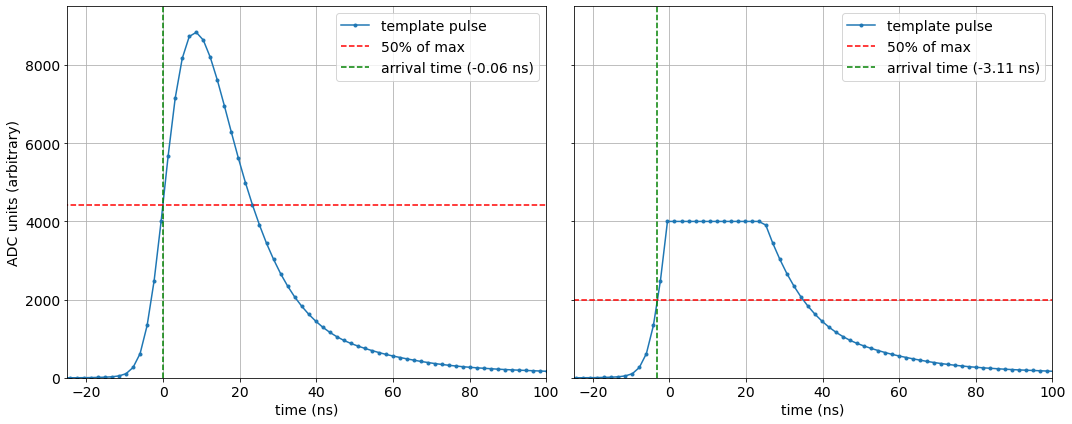

In [3]:
def Draw_Clipped_Example(graph, clipping_height = 4000, y_lim = 9500):
    
    x,y = get_xy_from_TGraph(graph)
    plt.figure(figsize=(14, 6), dpi=150)
    fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))

    ax[0].plot(x,y, linestyle='-', marker='.', label='template pulse')
    ax[0].plot([x[0],x[-1]], [np.amax(y)/2,np.amax(y)/2], linestyle='--', marker='', color='r', label='50% of max')
    ax[0].plot([get_time(x, y), get_time(x, y)], [0,y_lim], linestyle='--', color='g', label='arrival time ('+str(np.round(get_time(x, y),2)) + ' ns)')
    ax[0].grid()
    ax[0].set_xlabel('time (ns)', fontsize=14); ax[0].set_ylabel('ADC units (arbitrary)', fontsize=14)
    ax[0].legend(fontsize=14)
    ax[0].set_ylim(0,y_lim)
    ax[0].set_xlim(-25, 100)
    ax[0].tick_params(axis='both', labelsize=14)

    yscaled_clipped = np.copy(y)
    yscaled_clipped[yscaled_clipped > clipping_height] = clipping_height

    ax[1].plot(x,yscaled_clipped, linestyle='-', marker='.', label='template pulse')
    ax[1].plot([x[0],x[-1]], [np.amax(yscaled_clipped)/2,np.amax(yscaled_clipped)/2], linestyle='--', marker='', color='r', label='50% of max')
    ax[1].plot([get_time(x, yscaled_clipped), get_time(x, yscaled_clipped)], [0,y_lim], linestyle='--', color='g', label='arrival time ('+str(np.round(get_time(x, yscaled_clipped),2)) + ' ns)')
    ax[1].grid()
    ax[1].set_xlabel('time (ns)', fontsize=14); ax[0].set_ylabel('ADC units (arbitrary)', fontsize=14)
    ax[1].legend(fontsize=14)
    ax[1].set_ylim(0,y_lim)
    ax[1].set_xlim(-25, 100)
    ax[1].tick_params(axis='both', labelsize=14)

    plt.tight_layout()

    
Draw_Clipped_Example(graph_early)

#gStyle.SetOptStat(0)
#c = ROOT.TCanvas()
#graph_early.Draw("AP")
#c.Draw()
#print(len(x))

### Time Reconstruction ###  
By scanning backwards from the maximum ADC sample, the particle’s arrival time $t$ is interpolated using the first level crossing between the 50% of the maximum. This is indicated by the vertical green line and should occur between the two leading ADC samples; however, this cannot be determined accurately if the waveform is clipped. This is because the second lead ADC sample may become undefined and is interpreted as the leading edge when clipping begins.    

### Pulse Shaped Discrimination Figure of Merit Reconstruction ### 
The parameter used to distinguish *electron-recoil* events from *nuclear-recoil* events is derived from the general shape of waveform. This is because charged particles will lose energy as they travel through the liquid scintillator. The relative amount of kinetic energy converted into scintillating light is dependent on the mass of the particle. This light is guided down the length of the detector segment and read by the PMTs. The parameter describing the shape of the waveform, referred to as the pulse shape discrimination **(PSD)** figure of merit, is determined by the *tail-to-total* ratio of the waveform distribution $Q(t)$. The limits of integration are selected to maximize the discriminating capabilities between neutron capture events and other $\gamma$-ray interactions.  

$$PSD=\frac{\int_{tail}Q(t)dt}{\int_{total}Q(t)dt}$$ 

The *tail* region of the distribution is between 11 and 50 samples after the 50% level crossing. The *total* area of the waveform is calculated from 1 sample before $t$ and 50 samples after $t$. If the pulse is clipped, the total integrated area is reduced from its true value. The tail area is typically unaffected. As a result, the PSD is fictitiously shifted towards larger values. 

### Method ###
Copies of the original template waveform were scaled by a small amount $dh$ up to a maximum $h_{max}$. At each scaling interval, the arrival time and the PSD were determined. It should be noted that the methods of integration and interpolation used here may differ from the implementation in the PROSPECT2X-Analysis framework. Regardless, the 6 copied waveforms begin to clip at different heights. These heights are set arbitrarily to multiples of the original. The relationship between the PSD and the pulse area, as well as the arrival time offset and the PSD, are illustrated below. 

<Figure size 2100x900 with 0 Axes>

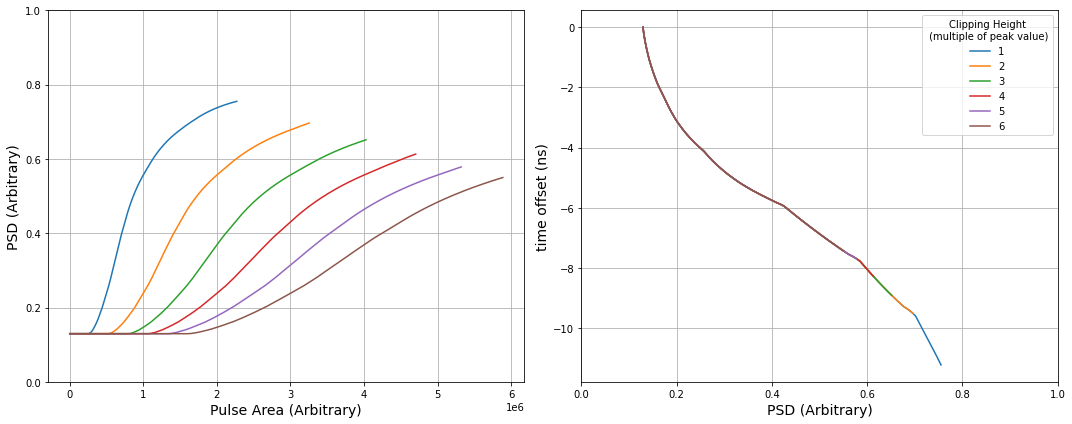

In [4]:
x,y = get_xy_from_TGraph(graph_early)

#create an array of scaled pulses where clipping occures at a multiple of it's max height
df_x1 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y))
df_x2 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y)*2)
df_x3 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y)*3)
df_x4 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y)*4)
df_x5 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y)*5)
df_x6 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y)*6)

dfarray = [[df_x1, 1], [df_x2, 2], [df_x3, 3], [df_x4, 4], [df_x5, 5], [df_x6, 6]]

#plot the change in PSD as the pulse scales as well as the PSD vs time offset

plt.figure(figsize=(14, 6), dpi=150)
fig, ax = plt.subplots(1,2, sharey=False, figsize=(15,6))

for df in dfarray: 
    ax[0].plot(np.asarray(df[0]['totalarea_clipped']), np.asarray(df[0]['PSD_clipped']), marker='', linestyle='-', label=str(df[1]))
    ax[1].plot(np.asarray(df[0]['PSD_clipped']), np.asarray(df[0]['time_offset']), marker='', linestyle='-')

ax[0].grid()
ax[0].set_ylim(0,1)
ax[0].set_xlabel('Pulse Area (Arbitrary)', fontsize=14) 
ax[0].set_ylabel('PSD (Arbitrary)', fontsize=14)

ax[1].grid()
ax[1].set_xlim(0,1)
ax[1].set_xlabel('Waveform Area (Arbitrary)', fontsize=14)
ax[1].set_xlabel('PSD (Arbitrary)', fontsize=14)
ax[1].set_ylabel('time offset (ns)', fontsize=14) 

#transfer the handles and lables from ax[0] to ax[1]
lines_labels = [x.get_legend_handles_labels() for x in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
leg = ax[1].legend(lines, labels, title = 'Clipping Height\n (multiple of peak value)') 
plt.setp(leg.get_title(), multialignment='center')

plt.tight_layout()

### Discussion ###
As seen in the figures above, the PSD does not change significantly as the waveform is scaled. Once clipping begins, the PSD scales quicky with the total area. It should be noted that the total pulse area is proportional to the deposited energy deposited into the segment channel. As a result, it may be possible to compare this distribution to calibrated data (simulated or otherwise). Consequentially the following study in this series of notebooks will demonstrate if this observed behavior matches how clipped events occur within PROSPECT. 